Group Members: Dhruv Baid, Prajakta Phadke, Uday Sharma

# External Modules {-}

In [1]:
# !pip install finbert-embedding
# !pip install gensim
# !pip install hmmlearn
# !pip install numpy==1.21.4
# !pip install pandas==1.5.1
# !pip install seaborn
# !pip install torch torchvision torchaudio
# !pip install transformers
# !pip install yahoofinance

# Imports/Settings {-}

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from datetime import datetime
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import sys

In [2]:
sys.path.append(os.getcwd() + '/modules')
from modules.cross_validation import Pipeline, CustomCrossValidation
from modules.data import *
from modules.directional_change import *
from modules.hidden_markov_model import make_regime_plots, fit_hmm
from modules.kmeans import *
from modules.logistic_regression import do_all_LR
from modules.MixtureModels import *
from modules.NaiveBayesClassifier import *
from modules.svm import do_all_SVM
from modules.text_preprocessing import *
from modules.timeseries import *
from modules.topic_modeling import *
from modules.trading_strategy import *
from modules.visualization import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhruv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhruv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
plt.style.use('seaborn')
sns.set_theme()

# Assign Train/Test Dates {-}

In [3]:
period_start = datetime(1985, 1, 1)
period_end = datetime(2023, 6, 30)

train_start = datetime(1985, 1, 1)
train_end = datetime(2019, 12, 31)
test_start = datetime(2020, 1, 1)
test_end = datetime(2023, 6, 30)

# Unsupervised Learning (Label Generation) {-}

## Natural Language Processing {-}

### Text Data - Reading {-}

In [4]:
FOMC_FPATH = '../fomc_documents/fomc_documents.csv'
# FOMC_PATH = 'data/fomc_documents.csv'

In [5]:
fomc_data = get_text_data(fpath=FOMC_FPATH)
fomc_data

,document_kind,meeting_date,release_date,text,url
2947,minutes_of_actions,1985-02-13,1985-03-15,Meeting of the Federal Open Market Committee F...,https://www.federalreserve.gov/monetarypolicy/...
2960,minutes_of_actions,1985-03-26,1985-04-25,Meeting of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...
2968,minutes_of_actions,1985-05-21,1985-06-20,Meeting of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...
2982,minutes_of_actions,1985-07-10,1985-08-09,Meeting of the Federal Open Market Committee J...,https://www.federalreserve.gov/monetarypolicy/...
2992,minutes_of_actions,1985-08-20,1985-09-19,Meeting of the Federal Open Market Committee A...,https://www.federalreserve.gov/monetarypolicy/...
...,...,...,...,...,...
5933,minutes,2022-12-14,2023-01-04,Minutes of the Federal Open Market Committee D...,https://www.federalreserve.gov/monetarypolicy/...
5936,minutes,2023-02-01,2023-02-22,Minutes of the Federal Open Market Committee J...,https://www.federalreserve.gov/monetarypolicy/...
5940,minutes,2023-03-22,2023-04-12,Minutes of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...
5946,minutes,2023-05-03,2023-05-24,Minutes of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...


### Text Data - Pre-Processing {-}

In [6]:
# Remove names
fomc_data.text = fomc_data.text.apply(remove_names_from_minutes)

# Remove stop-words
fomc_data.text = fomc_data.text.apply(tokenizer_wo_stopwords)

# Set index as meeting_date
fomc_data.set_index('meeting_date', inplace=True)

fomc_data

,document_kind,release_date,text,url
meeting_date,,,,
1985-02-13,minutes_of_actions,1985-03-15,vote gerald corrigan elected serve vice chairm...,https://www.federalreserve.gov/monetarypolicy/...
1985-03-26,minutes_of_actions,1985-04-25,vote following officers open market elected se...,https://www.federalreserve.gov/monetarypolicy/...
1985-05-21,minutes_of_actions,1985-06-20,vote actions taken open market held march appr...,https://www.federalreserve.gov/monetarypolicy/...
1985-07-10,minutes_of_actions,1985-08-09,vote actions taken open market held approved,https://www.federalreserve.gov/monetarypolicy/...
1985-08-20,minutes_of_actions,1985-09-19,vote actions taken open market held july approved,https://www.federalreserve.gov/monetarypolicy/...
...,...,...,...,...
2022-12-14,minutes,2023-01-04,vote selected richard ostrander serve deputy g...,https://www.federalreserve.gov/monetarypolicy/...
2023-02-01,minutes,2023-02-22,vote following officers selected serve selecti...,https://www.federalreserve.gov/monetarypolicy/...
2023-03-22,minutes,2023-04-12,turned review financial market developments in...,https://www.federalreserve.gov/monetarypolicy/...


In [7]:
# Define train and test data
train_data = fomc_data[(fomc_data.index >= train_start) & (fomc_data.index <= train_end)]
test_data = fomc_data[(fomc_data.index >= test_start) & (fomc_data.index <= test_end)]

### TF-IDF Values Computation {-}

In [8]:
# Compute TF-IDF values
tfidf_class = TF_IDF(X_train=train_data.text, X_test=test_data.text)

tfidf_class.fit_manual()
tfidf_class.fit_gensim()

### Label Generation using K-Means Clustering on TF-IDF Values {-}

In [9]:
# Train KMeans Clustering
model_kmeans = KMeansCluster(
    k=2,
    X_train=preprocessing.normalize(tfidf_class.tfidf_gensim_train),
    X_test=preprocessing.normalize(tfidf_class.tfidf_gensim_test),
)
model_kmeans.fit()
model_kmeans.predict()

In [10]:
display(pd.merge(
    left=model_kmeans.sizes_train_df,
    right=model_kmeans.sizes_test_df,
    left_index=True,
    right_index=True,
    suffixes=('_TRAIN', '_TEST'),
)['CLUSTER_SIZE_TRAIN'])

,CLUSTER_SIZE_TRAIN,CLUSTER_SIZE_TEST
CLUSTER,,
0,177,24
1,104,4


In [11]:
assert model_kmeans.labels_.shape[0] == train_data.shape[0]
assert model_kmeans.y_test_pred.shape[0] == test_data.shape[0]

nlp_regimes_train = pd.DataFrame.from_dict({
    'NLP_Regimes': model_kmeans.labels_
}).set_index(train_data.index)
nlp_regimes_test = pd.DataFrame.from_dict({
    'NLP_Regimes': model_kmeans.y_test_pred
}).set_index(pd.to_datetime(test_data.index))

display(nlp_regimes_train)
# display(nlp_regimes_test)

,NLP_Regimes
meeting_date,
1985-02-13,1
1985-03-26,1
1985-05-21,1
1985-07-10,1
1985-08-20,1
...,...
2019-06-19,0
2019-07-31,0
2019-09-18,0


,NLP_Regimes
meeting_date,
2020-01-29,1
2020-03-15,0
2020-04-29,0
2020-06-10,0
2020-07-29,0
2020-09-16,0
2020-11-05,0
2020-12-16,0
2021-01-27,1


### Wordcloud Generation using Labels (Training Data) {-}

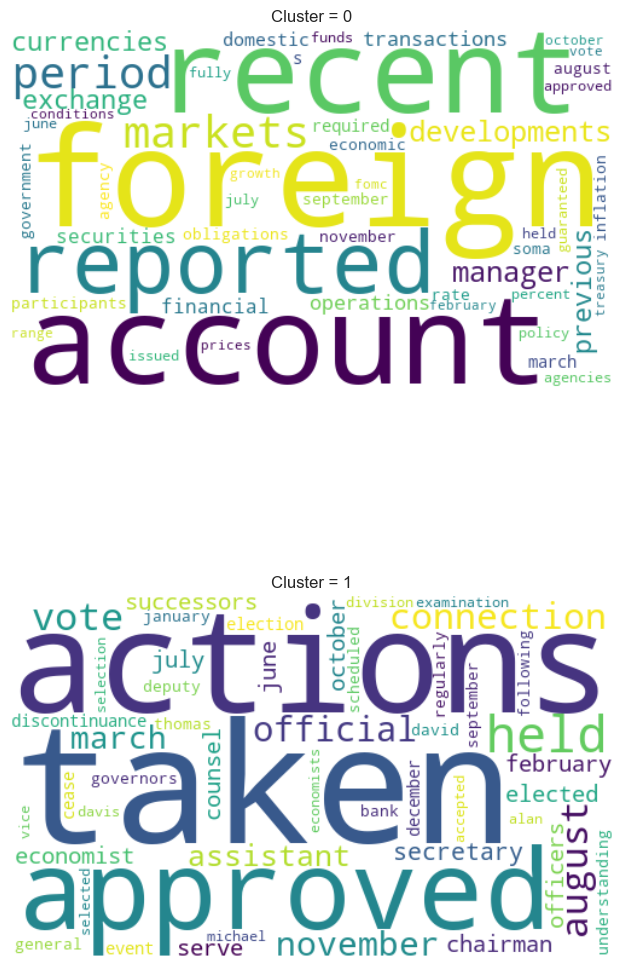

In [12]:
wordcloud_clusters(
    model_kmeans.model,
    preprocessing.normalize(tfidf_class.tfidf_gensim_train),
    tfidf_class.dict_gensim_statements,
)

## Hidden Markov Models {-}

### Price Data - Reading {-}

In [13]:
epsilon = 0.5
theta = 0.01
trading_day = {'equity':12, 'fx':12,'bond':12}

In [14]:
df_ts = get_ts_data(
    '^GSPC',
    start_date=period_start,
    end_date=period_end,
    delta=trading_day['equity']
)

[*********************100%%**********************]  1 of 1 completed


Date
1985-01-02 00:00:00     165.369995
1985-01-02 12:00:00     167.199997
1985-01-03 00:00:00     164.570007
1985-01-03 12:00:00     165.369995
1985-01-04 00:00:00     163.679993
                          ...     
2019-12-27 12:00:00    3247.229980
2019-12-30 00:00:00    3221.290039
2019-12-30 12:00:00    3240.090088
2019-12-31 00:00:00    3230.780029
2019-12-31 12:00:00    3215.179932
Length: 17644, dtype: float64

### Price Data - Pre-Processing {-}

In [ ]:
df_ts_train = df_ts[(df_ts.index.date >= train_start.date()) & (df_ts.index.date <= train_end.date())]
df_ts_test = df_ts[(df_ts.index.date >= test_start.date()) & (df_ts.index.date <= test_end.date())]

df_ts_train

In [15]:
def get_r_values(data):
    r_values = get_R(
        get_TMV(get_DC_data_v2(data, theta), theta),
        get_T(get_DC_data_v2(data, theta)),
        theta
    )
    return r_values

r_values_train = get_r_values(df_ts_train)
r_values_test = get_r_values(df_ts_test)

### Label Generation using HMMs on Indicator Values (derived from Price Data) {-}

In [16]:
hmm_regimes_train, hmm_model = fit_hmm(
    2,
    df_ts_train,
    r_values_train,
    '^GSPC',
    plot=False,
    verbose=False
)

hmm_regimes_test = hmm_model.predict(r_values_test.values.reshape(-1, 1))

In [17]:
hmm_regimes_train = pd.DataFrame.from_dict({
    'HMM_Regimes': list(hmm_regimes_train.values),
}).set_index(r_values_train.index)

hmm_regimes_test = pd.DataFrame.from_dict({
    'HMM_Regimes': hmm_regimes_test,
}).set_index(r_values_test.index)

In [ ]:
display(hmm_regimes_train)

## Fill Labels Across Entire Time Period

In [18]:
train_regimes = pd.DataFrame(index=pd.date_range(
    start=period_start,
    end=train_end + timedelta(1),
    freq='12H'
)[:-1])

train_regimes = pd.merge(
    left=train_regimes,
    right=nlp_regimes_train,
    how="left",
    left_index=True,
    right_index=True,
).bfill()

train_regimes = pd.merge(
    left=train_regimes,
    right=hmm_regimes_train,
    how="left",
    left_index=True,
    right_index=True,
).bfill()

train_regimes.NLP_Regimes = train_regimes.NLP_Regimes.ffill()
train_regimes.HMM_Regimes = train_regimes.HMM_Regimes.ffill()

train_regimes

,NLP_Regimes,HMM_Regimes
1985-01-01 00:00:00,1.0,0.0
1985-01-01 12:00:00,1.0,0.0
1985-01-02 00:00:00,1.0,0.0
1985-01-02 12:00:00,1.0,0.0
1985-01-03 00:00:00,1.0,1.0
...,...,...
2019-12-29 12:00:00,0.0,1.0
2019-12-30 00:00:00,0.0,1.0
2019-12-30 12:00:00,0.0,1.0
2019-12-31 00:00:00,0.0,1.0


# Supervised Learning {-}

## Feature Engineering

### Topic Modeling {-}

In [20]:
topicmod = TopicModel(
    tfidf_class.tfidf_statements_train,
    tfidf_class.dict_gensim_statements,
    tfidf_class.X_train.apply(tokenizer_wo_stopwords).tolist(),
    crossval=False,
)

In [21]:
topicmod.fit()

In [24]:
X_test = tfidf_class.X_test.apply(tokenizer_wo_stopwords).apply(lambda x: x.split(" "))
bow_test = [tfidf_class.dict_gensim_statements.doc2bow(text) for text in X_test]

pdf_test = []

for i in range(len(X_test)):
    topic_pdf = topicmod.cv_model[bow_test][i]
    topic_pdf = {topic:pdf for topic, pdf in topic_pdf}
    cur_doc_pdf = []
    for i in range(10):
        if i in topic_pdf:
            cur_doc_pdf.append(topic_pdf[i])
        else:
            cur_doc_pdf.append(0.0)
    pdf_test.append(cur_doc_pdf)

pdf_test = np.array(pdf_test)
print(pdf_test.shape)

(28, 10)


In [25]:
topic_models_train = pd.DataFrame(
    topicmod.doc_mat,
    columns=[f"Topic_{i}" for i in range(10)],
    index=tfidf_class.X_train.index
)

topic_models_test = pd.DataFrame(
    pdf_test,
    columns=[f"Topic_{i}" for i in range(10)],
    index=tfidf_class.X_test.index
)

### FinBERT Word Embeddings

In [27]:
from finbert_embedding.embedding import FinbertEmbedding
finbert = FinbertEmbedding()

In [28]:
def word_embedding_to_np(text: str):
    sentence_embedding = finbert.sentence_vector(text)
    res = np.array(list(map(lambda x: x.detach().numpy(), sentence_embedding)))
    return res

In [29]:
finbert_embeddings_train = train_data.text.apply(word_embedding_to_np)
finbert_embeddings_test = test_data.text.apply(word_embedding_to_np)

In [30]:
finbert_embeddings_train = pd.DataFrame(
    np.array(list(map(lambda x: list(x), finbert_embeddings_train.values))),
    columns=[f"Word {i}" for i in range(len(finbert_embeddings_train.values[0]))],
    index=train_data.index,
)

finbert_embeddings_test = pd.DataFrame(
    np.array(list(map(lambda x: list(x), finbert_embeddings_test.values))),
    columns=[f"Word {i}" for i in range(len(finbert_embeddings_test.values[0]))],
    index=test_data.index,
)

# Prepare NMF Topic Models and FinBERT Word Embeddings

In [31]:
index_train = r_values_train.index
X_train = pd.DataFrame(index=index_train)

# ffill() topic model PDFs to account for dates on which we have text data but no DC data
topic_models_train_new = pd.merge(
    left=X_train,
    right=topic_models_train,
    how='outer',
    left_index=True,
    right_index=True
).ffill()
topic_models_train_new = topic_models_train_new[topic_models_train_new.index.isin(index_train)]

# ffill() word embeddings to account for dates on which we have text data but no DC data
finbert_embeddings_train_new = pd.merge(
    left=X_train,
    right=finbert_embeddings_train,
    how='outer',
    left_index=True,
    right_index=True
).ffill()
finbert_embeddings_train_new = finbert_embeddings_train_new[finbert_embeddings_train_new.index.isin(index_train)]

# Add name to R Values Series
r_values_train.name = 'R_Values_Train'

In [32]:
index_test = r_values_test.index
X_test = pd.DataFrame(index=index_test)

# ffill() topic model PDFs to account for dates on which we have text data but no DC data
topic_models_test_new = pd.merge(
    left=X_test,
    right=topic_models_test,
    how='outer',
    left_index=True,
    right_index=True
).ffill()
topic_models_test_new = topic_models_test_new[topic_models_test_new.index.isin(index_test)]

# ffill() word embeddings to account for dates on which we have text data but no DC data
finbert_embeddings_test_new = pd.merge(
    left=X_test,
    right=finbert_embeddings_test,
    how='outer',
    left_index=True,
    right_index=True
).ffill()
finbert_embeddings_test_new = finbert_embeddings_test_new[finbert_embeddings_test_new.index.isin(index_test)]

# Add name to R Values Series
r_values_test.name = 'R_Values_Test'

# Prepare covariates and labels

In [33]:
# Flags to change covariates used in NB Classifier
USE_TOPIC_MODEL_PDF = True
USE_WORD_EMBEDDINGS = True
USE_R_VALUES = True

In [34]:
def make_X(
    train: bool = True,
    topic_model: bool = USE_TOPIC_MODEL_PDF,
    word_embeddings: bool = USE_WORD_EMBEDDINGS,
    price_data: bool = USE_R_VALUES,
):
    """
    This function creates a new DataFrame of covariates based on the flags which
    determine specifically which covariates will be included.

    @param train: flag for deciding if making train or test data
    @param topic_model: flag for including NMF Topic Models (loadings)
    @param word_embeddings: flag for including Finbert Word Embeddings
    @param topic_model: flag for including R Indicator Values (price data)
    @return X: pd.DataFrame indexed by DC Indicators containing specified covariates
    """
    if train:
        index = r_values_train.index
        topic_models_df = topic_models_train_new.copy()
        word_embeddings_df = finbert_embeddings_train_new.copy()
        r_values_df = r_values_train.copy()
    else:
        index = r_values_test.index
        topic_models_df = topic_models_test_new.copy()
        word_embeddings_df = finbert_embeddings_test_new.copy()
        r_values_df = r_values_test.copy()
    
    X = pd.DataFrame(index=index)
    
    # Add topic model PDFs to covariates DataFrame
    if topic_model:
        X = pd.merge(
            left=X,
            right=topic_models_df,
            how='inner',
            left_index=True,
            right_index=True
        )
    
    # Add word embeddings to covariates DataFrame
    if word_embeddings:
        X = pd.merge(
            left=X,
            right=word_embeddings_df,
            how='inner',
            left_index=True,
            right_index=True
        )
    
    # Add DC Indicator (price data) to covariates DataFrame
    if USE_R_VALUES:
        X = pd.merge(
            left=X,
            right=r_values_df,
            how='inner',
            left_index=True,
            right_index=True
        )
    
    # TODO: either bfill() here, or remove the NA rows from y_train and X_train
    X = X.bfill()

    if train:
        print(f"X_train: {X.shape}")
    else:
        print(f"X_test: {X.shape}")

    return X

In [35]:
def make_Y(
    train: bool = True,
):
    """
    This function constructs the NLP and HMM y-labels.

    @param train: flag for deciding if making train or test data
    @return (y_nlp, y_hmm): tuple containing NLP and HMM y-labels
    """
    if train:
        regimes = train_regimes.copy()
        index = index_train.copy()
    else:
        regimes = test_regimes.copy()
        index = index_test.copy()
    
    regimes = regimes[regimes.index.isin(index)]
    
    y_nlp = regimes.NLP_Regimes
    y_hmm = regimes.HMM_Regimes

    if train:
        print(f"y_train_nlp: {y_nlp.shape}")
        print(f"y_train_hmm: {y_hmm.shape}")
    else:
        print(f"y_test_nlp: {y_nlp.shape}")
        print(f"y_test_hmm: {y_hmm.shape}")
    
    return y_nlp, y_hmm

In [36]:
def make_data_NB(
    topic_model: bool = USE_TOPIC_MODEL_PDF,
    word_embeddings: bool = USE_WORD_EMBEDDINGS,
    price_data: bool = USE_R_VALUES,
):
    """
    This function creates all X and y data for the classification model.

    @param topic_model: flag for including NMF Topic Models (loadings)
    @param word_embeddings: flag for including Finbert Word Embeddings
    @param topic_model: flag for including R Indicator Values (price data)
    @return (X_train, X_test, y_train_nlp, y_train_hmm, y_test_nlp, y_test_nlp): tuple containing all train and test data
    """
    X_train = make_X(
        train=True,
        topic_model=topic_model,
        word_embeddings=word_embeddings,
        price_data=price_data
    )
    X_test = make_X(
        train=False,
        topic_model=topic_model,
        word_embeddings=word_embeddings,
        price_data=price_data
    )
    y_train_nlp, y_train_hmm = make_Y(train=True)
    # y_test_nlp, y_test_hmm = make_Y(train=False)
    return X_train, X_test, y_train_nlp, y_train_hmm

In [37]:
X_train, X_test, y_train_nlp, y_train_hmm = make_data_NB()

X_train: (4932, 779)
X_test: (563, 779)
y_train_nlp: (4932,)
y_train_hmm: (4932,)


In [38]:
# X_train, X_test, y_train_nlp, y_train_hmm, y_test_nlp, y_test_nlp = pd.read_pickle('assets/X_train.pkl'), pd.read_pickle('assets/X_test.pkl'), pd.read_pickle('assets/y_train_nlp.pkl'), \
#     pd.read_pickle('assets/y_train_hmm.pkl'), pd.read_pickle('assets/y_test_nlp.pkl'), pd.read_pickle('assets/y_test_hmm.pkl')

# Naive Bayes Classifier

## Prediction for NLP and HMM Labels, for DC indicators, NMF loadings, and FinBERT embeddings

In [39]:
test_regimes = pd.DataFrame(index=pd.date_range(
    start=test_start,
    end=period_end + timedelta(1),
    freq='12H'
)[:-1])

def add_to_regime_dataframe(X_train, y_train, X_test, label, test_regimes):
    y_pred = do_all_NBC(
        X_train.values,
        y_train.values,
        X_test.values,
    )

    y_pred = pd.DataFrame.from_dict({
        label: y_pred
    }).set_index(index_test)

    test_regimes = pd.merge(
        left=test_regimes,
        right=y_pred,
        how="left",
        left_index=True,
        right_index=True,
    ).bfill()

    test_regimes[label] = test_regimes[label].ffill()
    return test_regimes

test_regimes = add_to_regime_dataframe(X_train.iloc[:,-1:], pd.DataFrame(y_train_nlp), X_test.iloc[:,-1:], 'Kmeans_labels_DC_indicators', test_regimes)
test_regimes = add_to_regime_dataframe(X_train.iloc[:,:10], pd.DataFrame(y_train_nlp), X_test.iloc[:,:10], 'Kmeans_labels_NMF_loadings', test_regimes)
test_regimes = add_to_regime_dataframe(X_train.iloc[:,10:-1], pd.DataFrame(y_train_nlp), X_test.iloc[:,10:-1], 'Kmeans_labels_finBERT_embeddings', test_regimes)
test_regimes = add_to_regime_dataframe(X_train.iloc[:,-1:], pd.DataFrame(y_train_hmm), X_test.iloc[:,-1:], 'HMM_labels_DC_indicators', test_regimes)
test_regimes = add_to_regime_dataframe(X_train.iloc[:,:10], pd.DataFrame(y_train_hmm), X_test.iloc[:,:10], 'HMM_labels_NMF_loadings', test_regimes)
test_regimes = add_to_regime_dataframe(X_train.iloc[:,10:-1], pd.DataFrame(y_train_hmm), X_test.iloc[:,10:-1], 'HMM_labels_finBERT_embeddings', test_regimes)

## Trading Strategy Evaluation

In [40]:
""" Run the control strategy on test data. """
results = []
result_labels = ['Control 1', 'Control 2', 'K-means labels, only DC covariates', 'K-means labels, NMF loading covariates', 'K-means labels, FinBERT embeddings','HMM labels, only DC covariates', 'HMM labels, NMF loading covariates', 'HMM labels, FinBERT embeddings']

strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control', start_date =  str(train_start)[:10], train_end = str(train_end)[:10], \
    test_start =  str(test_start)[:10], theta = theta, epsilon = 0.5, provide_labels = True, labels = test_regimes[test_regimes.columns[0]]) # labels are a placeholder for control
strat_test.fit(verbose = False)
results.append(strat_test.trading_metrics_test)
print(f"Control 1 done")

strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control2', start_date =  str(train_start)[:10], train_end = str(train_end)[:10], \
    test_start =  str(test_start)[:10], theta = theta, epsilon = 0.5,  provide_labels = True, labels = test_regimes[test_regimes.columns[0]])
strat_test.fit(verbose = False)
results.append(strat_test.trading_metrics_test)
print(f"Control 2 done")

for label, column in zip(result_labels[2:], test_regimes.columns):
    """ Run the strategy on test data. """
    strat_test = Pipeline(df_ts= df_ts, to_test = True, start_date =  str(train_start)[:10], train_end = str(train_end)[:10], \
        test_start =  str(test_start)[:10], theta = theta, epsilon = 0.5,  provide_labels = True, labels = test_regimes[column])
    strat_test.fit(verbose = False)
    print(f"{label} done")
    results.append(strat_test.trading_metrics_test)

In [41]:
pd.DataFrame(results, index = result_labels).round(8).sort_values('sharpe')

,drawdown,profit,sharpe
"K-means labels, NMF loading covariates",0.154341,0.530849,0.540878
Control 1,0.154341,0.530849,0.541172
"K-means labels, only DC covariates",0.154341,0.530849,0.541172
"K-means labels, FinBERT embeddings",0.154341,0.530849,0.541172
"HMM labels, FinBERT embeddings",0.154341,0.530849,0.541172
Control 2,0.154564,0.529506,0.616659
"HMM labels, NMF loading covariates",0.158274,0.530849,0.618412
"HMM labels, only DC covariates",0.222633,0.901848,0.710041


# SVM Classifier

## Prediction for NLP and HMM Labels, for DC indicators, NMF loadings, and FinBERT embeddings

In [42]:
test_regimes = pd.DataFrame(index=pd.date_range(
    start=test_start,
    end=period_end + timedelta(1),
    freq='12H'
)[:-1])

def add_to_regime_dataframe(X_train, y_train, X_test, label, test_regimes):
    y_pred = do_all_SVM(
        X_train.values,
        y_train.values,
        X_test.values,
    )

    y_pred = pd.DataFrame.from_dict({
        label: y_pred
    }).set_index(index_test)

    test_regimes = pd.merge(
        left=test_regimes,
        right=y_pred,
        how="left",
        left_index=True,
        right_index=True,
    ).bfill()

    test_regimes[label] = test_regimes[label].ffill()
    return test_regimes

test_regimes = add_to_regime_dataframe(X_train.iloc[:,-1:], pd.DataFrame(y_train_nlp), X_test.iloc[:,-1:], 'Kmeans_labels_DC_indicators', test_regimes)
test_regimes = add_to_regime_dataframe(X_train.iloc[:,:10], pd.DataFrame(y_train_nlp), X_test.iloc[:,:10], 'Kmeans_labels_NMF_loadings', test_regimes)
test_regimes = add_to_regime_dataframe(X_train.iloc[:,10:-1], pd.DataFrame(y_train_nlp), X_test.iloc[:,10:-1], 'Kmeans_labels_finBERT_embeddings', test_regimes)
test_regimes = add_to_regime_dataframe(X_train.iloc[:,-1:], pd.DataFrame(y_train_hmm), X_test.iloc[:,-1:], 'HMM_labels_DC_indicators', test_regimes)
test_regimes = add_to_regime_dataframe(X_train.iloc[:,:10], pd.DataFrame(y_train_hmm), X_test.iloc[:,:10], 'HMM_labels_NMF_loadings', test_regimes)
test_regimes = add_to_regime_dataframe(X_train.iloc[:,10:-1], pd.DataFrame(y_train_hmm), X_test.iloc[:,10:-1], 'HMM_labels_finBERT_embeddings', test_regimes)

## Trading Strategy Evaluation

In [45]:
""" Run the control strategy on test data. """
results = []
result_labels = ['Control 1', 'Control 2', 'K-means labels, only DC covariates', 'K-means labels, NMF loading covariates', 'K-means labels, FinBERT embeddings','HMM labels, only DC covariates', 'HMM labels, NMF loading covariates', 'HMM labels, FinBERT embeddings']

strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control', start_date =  str(train_start)[:10], train_end = str(train_end)[:10], \
    test_start =  str(test_start)[:10], theta = theta, epsilon = 0.5, provide_labels = True, labels = test_regimes[test_regimes.columns[0]]) # labels are a placeholder for control
strat_test.fit(verbose = False)
results.append(strat_test.trading_metrics_test)
print(f"Control 1 done")

strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control2', start_date =  str(train_start)[:10], train_end = str(train_end)[:10], \
    test_start =  str(test_start)[:10], theta = theta, epsilon = 0.5,  provide_labels = True, labels = test_regimes[test_regimes.columns[0]])
strat_test.fit(verbose = False)
results.append(strat_test.trading_metrics_test)
print(f"Control 2 done")

for label, column in zip(result_labels[2:], test_regimes.columns):
    """ Run the strategy on test data. """
    strat_test = Pipeline(df_ts= df_ts, to_test = True, start_date =  str(train_start)[:10], train_end = str(train_end)[:10], \
        test_start =  str(test_start)[:10], theta = theta, epsilon = 0.5,  provide_labels = True, labels = test_regimes[column])
    strat_test.fit(verbose = False)
    print(f"{label} done")
    results.append(strat_test.trading_metrics_test)

Control 1 done
Control 2 done
K-means labels, only DC covariates done
K-means labels, NMF loading covariates done
K-means labels, FinBERT embeddings done
HMM labels, only DC covariates done
HMM labels, NMF loading covariates done
HMM labels, FinBERT embeddings done


In [46]:
pd.DataFrame(results, index = result_labels).round(8).sort_values('sharpe')

,drawdown,profit,sharpe
"HMM labels, FinBERT embeddings",0.220305,0.502490,0.519751
"K-means labels, FinBERT embeddings",0.154341,0.502490,0.524675
Control 1,0.154341,0.530849,0.541172
"K-means labels, only DC covariates",0.154341,0.530849,0.541172
"K-means labels, NMF loading covariates",0.154341,0.511204,0.548407
"HMM labels, NMF loading covariates",0.220305,0.511204,0.568708
Control 2,0.154564,0.529506,0.616659
"HMM labels, only DC covariates",0.222633,0.901848,0.710041


# Logistic Regression Classifier

## Prediction for NLP and HMM Labels, for DC indicators, NMF loadings, and FinBERT embeddings

In [47]:
test_regimes = pd.DataFrame(index=pd.date_range(
    start=test_start,
    end=period_end + timedelta(1),
    freq='12H'
)[:-1])

def add_to_regime_dataframe(X_train, y_train, X_test, label, test_regimes):
    y_pred = do_all_LR(
        X_train.values,
        y_train.values,
        X_test.values,
    )

    y_pred = pd.DataFrame.from_dict({
        label: y_pred
    }).set_index(index_test)

    test_regimes = pd.merge(
        left=test_regimes,
        right=y_pred,
        how="left",
        left_index=True,
        right_index=True,
    ).bfill()

    test_regimes[label] = test_regimes[label].ffill()
    return test_regimes

test_regimes = add_to_regime_dataframe(X_train.iloc[:,-1:], pd.DataFrame(y_train_nlp), X_test.iloc[:,-1:], 'Kmeans_labels_DC_indicators', test_regimes)
test_regimes = add_to_regime_dataframe(X_train.iloc[:,:10], pd.DataFrame(y_train_nlp), X_test.iloc[:,:10], 'Kmeans_labels_NMF_loadings', test_regimes)
test_regimes = add_to_regime_dataframe(X_train.iloc[:,10:-1], pd.DataFrame(y_train_nlp), X_test.iloc[:,10:-1], 'Kmeans_labels_finBERT_embeddings', test_regimes)
test_regimes = add_to_regime_dataframe(X_train.iloc[:,-1:], pd.DataFrame(y_train_hmm), X_test.iloc[:,-1:], 'HMM_labels_DC_indicators', test_regimes)
test_regimes = add_to_regime_dataframe(X_train.iloc[:,:10], pd.DataFrame(y_train_hmm), X_test.iloc[:,:10], 'HMM_labels_NMF_loadings', test_regimes)
test_regimes = add_to_regime_dataframe(X_train.iloc[:,10:-1], pd.DataFrame(y_train_hmm), X_test.iloc[:,10:-1], 'HMM_labels_finBERT_embeddings', test_regimes)

## Trading Strategy Evaluation

In [48]:
""" Run the control strategy on test data. """
results = []
result_labels = ['Control 1', 'Control 2', 'K-means labels, only DC covariates', 'K-means labels, NMF loading covariates', 'K-means labels, FinBERT embeddings','HMM labels, only DC covariates', 'HMM labels, NMF loading covariates', 'HMM labels, FinBERT embeddings']

strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control', start_date =  str(train_start)[:10], train_end = str(train_end)[:10], \
    test_start =  str(test_start)[:10], theta = theta, epsilon = 0.5, provide_labels = True, labels = test_regimes[test_regimes.columns[0]]) # labels are a placeholder for control
strat_test.fit(verbose = False)
results.append(strat_test.trading_metrics_test)
print(f"Control 1 done")

strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control2', start_date =  str(train_start)[:10], train_end = str(train_end)[:10], \
    test_start =  str(test_start)[:10], theta = theta, epsilon = 0.5,  provide_labels = True, labels = test_regimes[test_regimes.columns[0]])
strat_test.fit(verbose = False)
results.append(strat_test.trading_metrics_test)
print(f"Control 2 done")

for label, column in zip(result_labels[2:], test_regimes.columns):
    """ Run the strategy on test data. """
    strat_test = Pipeline(df_ts= df_ts, to_test = True, start_date =  str(train_start)[:10], train_end = str(train_end)[:10], \
        test_start =  str(test_start)[:10], theta = theta, epsilon = 0.5,  provide_labels = True, labels = test_regimes[column])
    strat_test.fit(verbose = False)
    print(f"{label} done")
    results.append(strat_test.trading_metrics_test)

Control 1 done
Control 2 done
K-means labels, only DC covariates done
K-means labels, NMF loading covariates done
K-means labels, FinBERT embeddings done
HMM labels, only DC covariates done
HMM labels, NMF loading covariates done
HMM labels, FinBERT embeddings done


In [49]:
pd.DataFrame(results, index = result_labels).round(8).sort_values('sharpe')

,drawdown,profit,sharpe
"K-means labels, FinBERT embeddings",0.154341,0.509879,0.535931
Control 1,0.154341,0.530849,0.541172
"K-means labels, only DC covariates",0.154341,0.530849,0.541172
"K-means labels, NMF loading covariates",0.154341,0.530849,0.541172
"HMM labels, FinBERT embeddings",0.158381,0.520688,0.541302
"HMM labels, NMF loading covariates",0.158274,0.522022,0.612402
Control 2,0.154564,0.529506,0.616659
"HMM labels, only DC covariates",0.222633,0.901848,0.710041
